In [1]:
!pip install torchsummary


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.models as model
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision
from torch.utils.data import DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from numpy import random
# !pip install focal_loss_torch
# from focal_loss.focal_loss import FocalLoss
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

# 
from torchsummary import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_26/1083700853.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [3]:
!mkdir output


In [4]:
import torch
import torch.nn as nn
from torchvision.models import densenet121


#no change in height and width 
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

#increases height and width by factor of 2 
def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )


class denseUnet(nn.Module):
    
    def __init__(self,encoder,pretrained=True, out_channels=1):
        super().__init__()

        self.encoder = densenet121(pretrained=True).features
        for param in self.encoder.parameters():
          param.requires_grad=False

        self.block1 = nn.Sequential(*self.encoder[:6])#h=32 channel=128
        self.block2 = nn.Sequential(*self.encoder[6:8])#h=16 channel=256
        self.block3 = nn.Sequential(*self.encoder[8:10])#h=8 channel=512

        self.bottleneck = nn.Sequential(*self.encoder[10:])#h=8 channel 1024
        self.conv_bottleneck = double_conv(1024, 1024)#h=8
        
        self.up_conv6=nn.ConvTranspose2d(1024,1024,kernel_size=2,stride=2,padding=0)
        self.conv6a=nn.Conv2d(1024,512,kernel_size=1,stride=1,padding=0)
        self.conv6 = double_conv(512 + 512, 512)#h=16
        
        self.up_conv7=nn.ConvTranspose2d(512,512,kernel_size=2,stride=2,padding=0)
        self.conv7a=nn.Conv2d(512,256,kernel_size=1,stride=1,padding=0)
        self.conv7 = double_conv(256 + 256, 256)#h=32
        
        self.up_conv8=nn.ConvTranspose2d(256,256,kernel_size=2,stride=2,padding=0)
        self.conv8a=nn.Conv2d(256,128,kernel_size=1,stride=1,padding=0)
        self.conv8 = double_conv(128 + 128, 128)#h=64
        self.up_conv9 = up_conv(128, 64)#h=128
        self.conv9 = double_conv(64, 64)#h=128
        self.up_conv10 = up_conv(64, 32)#h=256
        self.conv10 = double_conv(32, 32)#h=256
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)#h=256
        self.conv12=nn.BatchNorm2d(out_channels)
    def forward(self, x1):
        #x..h=256 channels=3
        block1 = self.block1(x1)#h=32 channel=128
        block2 = self.block2(block1)#h=16 c=256
        block3 = self.block3(block2)#h=8 c=512

        bottleneck = self.bottleneck(block3)#h=8 c=1024
        x = self.conv_bottleneck(bottleneck)#h=8 c=1024
        
        x = self.conv6a(x)#h=8 c=512
        if x.shape != block3.shape:
          x = TF.resize(x,size = block3.shape[2:])
        x = torch.cat([x, block3], dim=1)#h=8 c=1024        
        x = self.up_conv6(x)#h=16 c=1024
        x = self.conv6(x)#h=16 c=512

        x = self.conv7a(x)#h=16 c=256
        if x.shape != block2.shape:
          x = TF.resize(x,size = block2.shape[2:])
        x = torch.cat([x, block2], dim=1)#h=16 c=512
        x = self.up_conv7(x)#h=32 c=512
        x = self.conv7(x)#h=32 c=256

        x = self.conv8a(x)#h=32 c=128
        if x.shape != block1.shape:
          x = TF.resize(x,size = block1.shape[2:])
        x = torch.cat([x, block1], dim=1)#h=32 c=256
        x = self.up_conv8(x)#h=64 c=256
        x = self.conv8(x)#h=64 c=128

        x = self.up_conv9(x)#h=128 c=64
        x = self.conv9(x)#h=128 c=64

        x = self.up_conv10(x)#h=256 c=32
        x = self.conv10(x)#h=256 c=32

        x = self.conv11(x)
        return x


def dense_unet(output_dim: int=1, pretrained: bool=False):
    return denseUnet(densenet121, pretrained=pretrained, out_channels=output_dim)

In [5]:
class SlumDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.mask = os.listdir(mask_dir)

  def __len__(self):
    return len(self.mask)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.mask[index])

    # img_path = self.image_dir[index]
    # mask_path = self.mask_dir[index]

    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path), dtype = np.float32)
    # mask = np.array(Image.open(mask_path))

    mask = (mask//246.0)

    if self.transform != None:
      augmentations = self.transform(image = image,mask = mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image,mask

def save_checkpoint(state,filename = "my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

def check_accuracy(loader,model,accuracy_vals,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))

      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2*(preds*y).sum())/((preds+y).sum() + 1e-8)

  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # index = accu.cpu().data.numpy().argmax()
  print(accu.item())
  accuracy_vals.append(accu.item())

  print(f"Dice score: {dice_score/len(loader)}")
  model.train()

def save_predictions_as_imgs(loader,model,folder,device = "cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device = device)

    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()

    torchvision.utils.save_image(preds,f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y.unsqueeze(1),f"{folder}/{idx}.jpg")

  model.train()


def my_plot(epochs, loss):
  plt.xlabel("losses")
  plt.ylabel("Num of epochs")
  plt.plot(epochs, loss)

In [6]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    train_val,
    num_workers = 2,
    pin_memory = True,
):

  # train_img,train_mask,val_img,val_mask = distributeData(train_dir,train_maskdir,train_val)

  train_ds = SlumDataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  val_ds = SlumDataset(
      image_dir = val_dir,
      mask_dir = val_mask_dir,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False,
  )

  return train_loader, val_loader

In [7]:
# Dataset (BTP 1 and 2)
# Hyperparameters
# LEARNING_RATE = [1e-4,1e-3,1e-2]
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2
train_val = 0.8
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
train_valid = 0.8
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = '/kaggle/input/slumdata/updated_complete_data/train_img'
TRAIN_MASK_DIR = '/kaggle/input/slumdata/updated_complete_data/train_mask'
val_dir = '/kaggle/input/slumdata/updated_complete_data/val_img'
val_mask_dir = '/kaggle/input/slumdata/updated_complete_data/val_mask'
saved_folder = '/kaggle/working/output'

#small data

# TRAIN_IMG_DIR = '/kaggle/input/small-slum-data/small_data/train_img'
# TRAIN_MASK_DIR = '/kaggle/input/small-slum-data/small_data/train_mask'
# val_dir = '/kaggle/input/small-slum-data/small_data/val_img'
# val_mask_dir = '/kaggle/input/small-slum-data/small_data/val_mask'
# saved_folder = '/kaggle/working/output'

In [8]:
# Custom Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def train_fn(epoch,num_epochs,loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train):
  total_loss = 0.0
  total_iou = 0.0
  total_precision = 0.0
  total_recall = 0.0
  total_f1 = 0.0
  total_accuracy = 0.0
  accuracy_s = []

  length = len(loader);
  loop = tqdm(loader)

  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device = device)
    targets = targets.float().unsqueeze(1).to(device = device)
    targ = targets

    # forward
    with torch.cuda.amp.autocast():
      predictions = torch.sigmoid(model(data))

      loss = loss_fn(predictions,targets)
      total_loss += loss.item()

      # convert model outputs to binary mask using sigmoid and threshold
      predicted_masks = predictions
      predicted_masks = (predicted_masks > 0.5).float()

      preds = predicted_masks.cpu().numpy()
      yy = targ.cpu().numpy()

      # Calculate the intersection and union of the binary masks
      intersection = np.sum(preds * yy)
      union = np.sum(np.logical_or(preds, yy))
      iou = intersection / union

      precision = precision_score(yy.flatten(), preds.flatten())
      recall = recall_score(yy.flatten(), preds.flatten())
      f1 = f1_score(yy.flatten(), preds.flatten())
    
      for pred_mask,gt_mask in zip(preds,yy):
        x = np.mean(gt_mask.flatten() == pred_mask.flatten())
        accuracy_s.append(x)

      total_iou += iou
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      # total_accuracy += accuracy

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())

  average_loss = total_loss / length
  average_iou = total_iou / length
  average_precision = total_precision / length
  average_recall = total_recall / length
  average_f1 = total_f1 / length
  # average_accuracy = accuracy /length

  # Append metrics and losses to lists for plotting
  loss_train.append(average_loss)
  iou_train.append(average_iou)
  precision_train.append(average_precision)
  recall_train.append(average_recall)
  f1_train.append(average_f1)
  accuracy_train.append(np.mean(accuracy_s))

  print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {average_loss:.4f}, "
          f"IoU: {average_iou:.4f}, "
          f"Precision: {average_precision:.4f}, "
          f"Recall: {average_recall:.4f}, "
          f"F1: {average_f1:.4f},"
          f"Accuracy: {np.mean(accuracy_s):4f}"
  )


In [10]:
def dice_coefficient(predicted_mask, ground_truth_mask):
  intersection = np.sum(predicted_mask * ground_truth_mask)
  predicted_area = np.sum(predicted_mask)
  ground_truth_area = np.sum(ground_truth_mask)

  dice = (2.0 * intersection) / (predicted_area + ground_truth_area)
  return dice

def check_accuracy(loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_s = []
  precision_s = []
  f1_s = []
  iou_s = []
  recall_s = []
  accuracy_s = []
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      pred = torch.sigmoid(model(x))

      pred = (pred > 0.5).float()
      num_correct += (pred == y).sum()
      num_pixels += torch.numel(pred)
      preds = pred.cpu().numpy()
      yy = y.cpu().numpy()

      for pred_mask, gt_mask in zip(preds, yy):
        # Flatten the binary masks for precision calculation
        pred_mask_flat = pred_mask.flatten()
        gt_mask_flat = gt_mask.flatten()

        # Calculate recall score for the current mask
        recall = recall_score(gt_mask_flat, pred_mask_flat)
        recall_s.append(recall)

        # Calculate precision for the current mask
        precision = precision_score(gt_mask_flat, pred_mask_flat)
        precision_s.append(precision)

        # Calculate F1 score for the current mask
        f1 = f1_score(gt_mask_flat, pred_mask_flat)
        f1_s.append(f1)

        # Calculate the intersection and union of the binary masks
        intersection = np.sum(pred_mask * gt_mask)
        union = np.sum(np.logical_or(pred_mask, gt_mask))

        # Calculate IoU for the current mask
        iou = intersection / union
        iou_s.append(iou)

        # Calculate Accuarcy for the current mask
        accuracy = np.mean(gt_mask_flat == pred_mask_flat)
        accuracy_s.append(accuracy)

        dice_score = dice_coefficient(pred_mask, gt_mask)
        dice_s.append(dice_score)

  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # Calculate the average precision over the validation dataset
  average_precision = np.mean(precision_s)
  print(f"Average Precision: {average_precision:.4f}")

  #Calculate the average accuracy over the validation dataset
  accuracy_vals.append(np.mean(accuracy_s))
  print(f'Accuracy: {np.mean(accuracy_s)}')

  # Calculate the average Dice score over the validation dataset
  average_dice = np.mean(dice_s)
  print(f"Average Dice Score: {average_dice:.4f}")

  # Calculate the average F1 score over the validation dataset
  average_f1 = np.mean(f1_s)
  print(f"Average F1 Score: {average_f1:.4f}")

  # Calculate the average IoU score over the validation dataset
  average_iou = np.mean(iou_s)
  print(f"Average IoU Score: {average_iou:.4f}")

  # Calculate average metrics for the epoch
  iou_scores.append(average_iou)
  precision_scores.append(average_precision)
  recall_scores.append(np.mean(recall_s))
  f1_val.append(average_f1)
  dice_scores.append(average_dice)

  model.train()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 156MB/s]
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, 

Epoch [1/10], Loss: 0.2076, IoU: 0.5612, Precision: 0.7346, Recall: 0.7130, F1: 0.7152,Accuracy: 0.839149
=> Saving checkpoint
Got 39795733/46530560 with accuracy 85.52600860595703
Average Precision: 0.5564
Accuracy: 0.8552601344148878
Average Dice Score: 0.6767
Average F1 Score: 0.6767
Average IoU Score: 0.5307


100%|██████████| 178/178 [07:12<00:00,  2.43s/it, loss=0.167]


Epoch [2/10], Loss: 0.1894, IoU: 0.5784, Precision: 0.8141, Recall: 0.6731, F1: 0.7313,Accuracy: 0.861055
=> Saving checkpoint
Got 42422526/46530560 with accuracy 91.17132568359375
Average Precision: 0.7036
Accuracy: 0.9117132052569322
Average Dice Score: 0.7532
Average F1 Score: 0.7532
Average IoU Score: 0.6216


100%|██████████| 178/178 [07:18<00:00,  2.46s/it, loss=0.145]


Epoch [3/10], Loss: 0.1802, IoU: 0.5835, Precision: 0.8304, Recall: 0.6677, F1: 0.7352,Accuracy: 0.864511
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 43262931/46530560 with accuracy 92.97745513916016
Average Precision: 0.7744
Accuracy: 0.9297745610626651
Average Dice Score: 0.7638
Average F1 Score: 0.7638
Average IoU Score: 0.6397


100%|██████████| 178/178 [07:19<00:00,  2.47s/it, loss=0.196]


Epoch [4/10], Loss: 0.1756, IoU: 0.5955, Precision: 0.8325, Recall: 0.6822, F1: 0.7447,Accuracy: 0.868394
=> Saving checkpoint
Got 41976181/46530560 with accuracy 90.21206665039062
Average Precision: 0.6661
Accuracy: 0.9021206922934089
Average Dice Score: 0.7449
Average F1 Score: 0.7449
Average IoU Score: 0.6116


100%|██████████| 178/178 [07:13<00:00,  2.43s/it, loss=0.189]


Epoch [5/10], Loss: 0.1744, IoU: 0.5973, Precision: 0.8435, Recall: 0.6770, F1: 0.7463,Accuracy: 0.869912
=> Saving checkpoint
Got 42500117/46530560 with accuracy 91.33806610107422
Average Precision: 0.7081
Accuracy: 0.9133807330064371
Average Dice Score: 0.7602
Average F1 Score: 0.7602
Average IoU Score: 0.6317


100%|██████████| 178/178 [07:12<00:00,  2.43s/it, loss=0.187]


Epoch [6/10], Loss: 0.1734, IoU: 0.6006, Precision: 0.8440, Recall: 0.6800, F1: 0.7491,Accuracy: 0.871647
=> Saving checkpoint
Got 41599946/46530560 with accuracy 89.40348815917969
Average Precision: 0.6542
Accuracy: 0.894034931021677
Average Dice Score: 0.7369
Average F1 Score: 0.7369
Average IoU Score: 0.6029


100%|██████████| 178/178 [07:19<00:00,  2.47s/it, loss=0.227]


Epoch [7/10], Loss: 0.1727, IoU: 0.6012, Precision: 0.8424, Recall: 0.6825, F1: 0.7492,Accuracy: 0.871686
=> Saving checkpoint
Got 42304776/46530560 with accuracy 90.91825866699219
Average Precision: 0.7044
Accuracy: 0.9091826103102993
Average Dice Score: 0.7568
Average F1 Score: 0.7568
Average IoU Score: 0.6277


100%|██████████| 178/178 [07:18<00:00,  2.46s/it, loss=0.203]


Epoch [8/10], Loss: 0.1724, IoU: 0.6076, Precision: 0.8369, Recall: 0.6949, F1: 0.7541,Accuracy: 0.872717
=> Saving checkpoint
Got 42014017/46530560 with accuracy 90.29338073730469
Average Precision: 0.6831
Accuracy: 0.9029338353116747
Average Dice Score: 0.7481
Average F1 Score: 0.7481
Average IoU Score: 0.6172


100%|██████████| 178/178 [07:10<00:00,  2.42s/it, loss=0.158]


Epoch [9/10], Loss: 0.1714, IoU: 0.6102, Precision: 0.8472, Recall: 0.6907, F1: 0.7563,Accuracy: 0.874374
=> Saving checkpoint
Got 41524696/46530560 with accuracy 89.24176788330078
Average Precision: 0.6556
Accuracy: 0.892417714293574
Average Dice Score: 0.7330
Average F1 Score: 0.7330
Average IoU Score: 0.5997


100%|██████████| 178/178 [07:19<00:00,  2.47s/it, loss=0.144]


Epoch [10/10], Loss: 0.1712, IoU: 0.6114, Precision: 0.8495, Recall: 0.6897, F1: 0.7572,Accuracy: 0.874730
=> Saving checkpoint
Got 41424305/46530560 with accuracy 89.02601623535156
Average Precision: 0.6477
Accuracy: 0.890260185993893
Average Dice Score: 0.7299
Average F1 Score: 0.7299
Average IoU Score: 0.5957
Training finished
loss_train : [0.20755366847086487, 0.18940051008811157, 0.18024863495250767, 0.17563822731543122, 0.17438806878047042, 0.1733901021018457, 0.17269518092442093, 0.1724188525355264, 0.17138603363144264, 0.17121271320273368]
iou_train : [0.5611669652722097, 0.5783792330561305, 0.5835368099186359, 0.5955074977337372, 0.5973005730160302, 0.6006036373972345, 0.6012189024158696, 0.6075758139910872, 0.6101548655729704, 0.611376396192547]
precision_train : [0.7345752437703159, 0.8141471408639138, 0.8303908265457177, 0.8324700416356815, 0.8435271750562783, 0.8440351762705711, 0.8424264219587121, 0.8368994785403414, 0.847166301864697, 0.8494777906548482]
recall_train : [

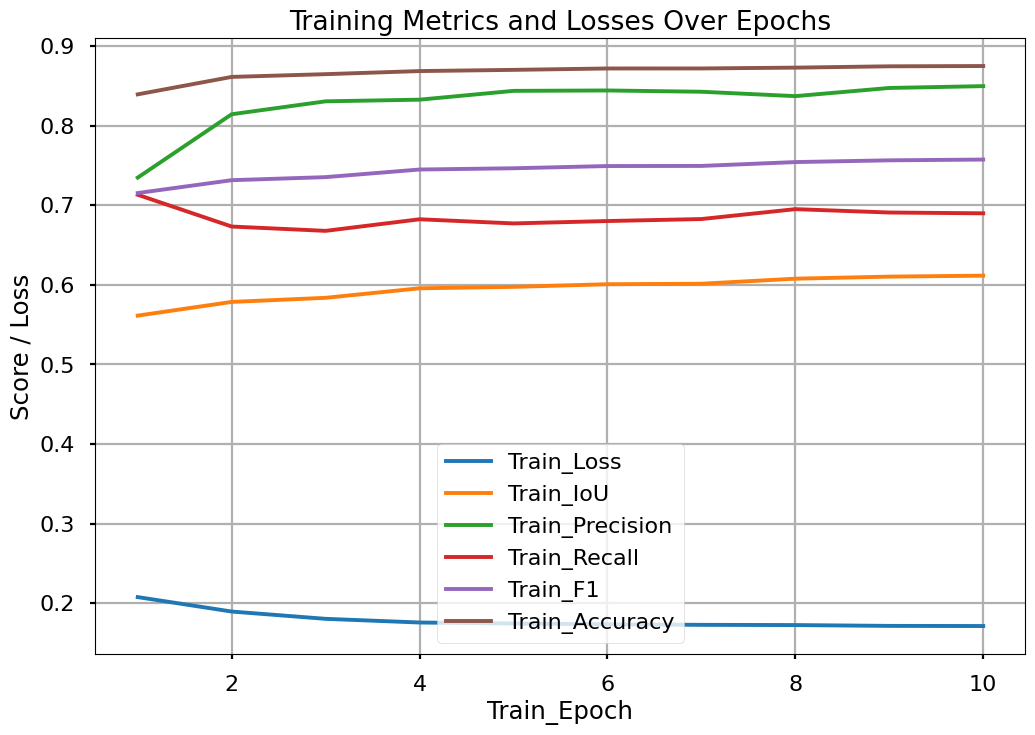

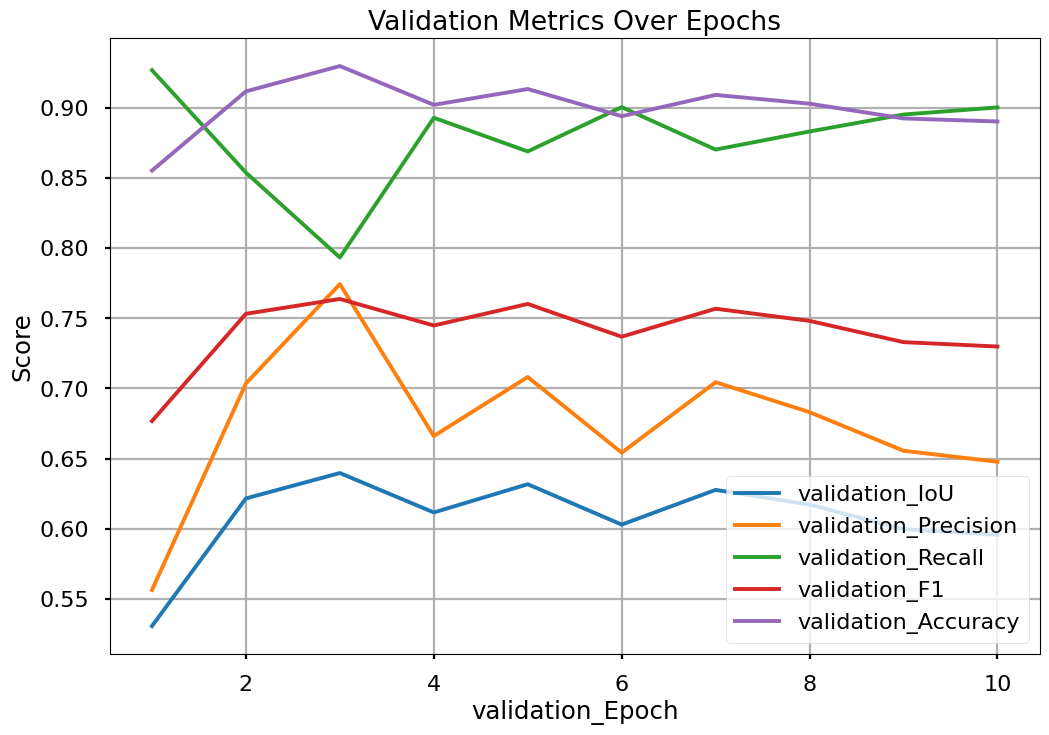

In [11]:
from torch.optim.lr_scheduler import StepLR
def main():
  # data augumentation:
  train_transform = A.Compose(
    [
      A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
      A.Rotate(limit = 35,p=1.0),
      A.HorizontalFlip(p=0.1),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0,0.0,0.0],
          std = [1.0,1.0,1.0],
          max_pixel_value = 255.0
      ),
      ToTensorV2(),
    ],is_check_shapes = False
  )

  val_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
     A.Normalize(
      mean=[0.0,0.0,0.0],
      std = [1.0,1.0,1.0],
      max_pixel_value = 255.0
    ),
    ToTensorV2(),
  ],is_check_shapes = False
  )

  # model instance:
  model = dense_unet().to(DEVICE)

  # defining loss:
  loss_fn = FocalLoss()

  #defining optimizer:
  optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

  # setting loaders:
  train_loader,val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      val_dir,
      val_mask_dir,
      BATCH_SIZE,
      train_transform,
      val_transform,
      train_val,
      NUM_WORKERS,
      PIN_MEMORY,
  )

  # if LOAD_MODEL :
  #   load_checkpoint(torch.load("my_checkpoint.pth.tar"),model,optimizer=optimizer)

  # check_accuracy(val_loader,model,device = DEVICE)

  scaler = torch.cuda.amp.GradScaler()


# Initialize lists to store metric values for each epoch for validation dataset
  iou_scores = []
  precision_scores = []
  recall_scores = []
  f1_val = []
  dice_scores = []
  accuracy_vals = []

 # Initialize lists to store metric values for each epoch for training dataset
  iou_train = []
  precision_train = []
  recall_train = []
  f1_train = []
  loss_train = []
  accuracy_train = []

 # Number of patience for early stopping
  patience = 10
  # best_val_loss = float('inf')
  best_val_loss = torch.tensor(float('inf'))
  counter = 0

  for epoch in range(NUM_EPOCHS):
    scheduler.step()
    train_fn(epoch,NUM_EPOCHS,train_loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check_accuracy
    val_loss = 0.0
    check_accuracy(val_loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,device = DEVICE)
            
    # print some examples to the folder
    save_predictions_as_imgs(
        val_loader,model,folder = saved_folder,device = DEVICE
    )
  print("Training finished")

  # Plot metrics and losses
  # Plot for Training dataset
  print(f'loss_train : {loss_train}')
  print(f'iou_train : {iou_train}')
  print(f'precision_train : {precision_train}')
  print(f'recall_train : {recall_train}')
  print(f'f1_train : {f1_train}')
  print(f'Accuracy_train : {accuracy_train}')

  
  print(f'Validation result')
  print(f'f1_val: {f1_val}')
  print(f'dice_scores : {dice_scores}')
  print(f'iou_scores : {iou_scores}')
  print(f'precision_scores : {precision_scores}')
  print(f'recall_scores : {recall_scores}')
  print(f'Accuracy_scores : {accuracy_vals}')

  # Plot metrics and losses
  # Plot for Training dataset
  epochs = np.arange(1, NUM_EPOCHS + 1)
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, loss_train, label='Train_Loss')
  plt.plot(epochs, iou_train, label='Train_IoU')
  plt.plot(epochs, precision_train, label='Train_Precision')
  plt.plot(epochs, recall_train, label='Train_Recall')
  plt.plot(epochs, f1_train, label='Train_F1')
  plt.plot(epochs, accuracy_train, label='Train_Accuracy')

  plt.xlabel('Train_Epoch')
  plt.ylabel('Score / Loss')
  plt.title('Training Metrics and Losses Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  # PLot validation metrics
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, iou_scores, label='validation_IoU')
  plt.plot(epochs, precision_scores, label='validation_Precision')
  plt.plot(epochs, recall_scores, label='validation_Recall')
  plt.plot(epochs, dice_scores, label='validation_F1')
  plt.plot(epochs,accuracy_vals,label = "validation_Accuracy")

  plt.xlabel('validation_Epoch')
  plt.ylabel('Score')
  plt.title('Validation Metrics Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

#   summary(model,input_size = (3,IMAGE_HEIGHT,IMAGE_WIDTH))

#   func(NUM_EPOCHS,loss_train,iou_train,precision_train,recall_train,f1_train,iou_scores,precision_scores,recall_scores, f1_val,dice_scores, accuracy_vals)

if __name__ == "__main__":
  main()